In [ ]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-0guphsag
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-0guphsag
  Resolved https://github.com/pydata/xarray.git to commit aa9e2bd407a47cef1ec7f1d9498e4a1118bc440e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import bambi as bmb

In [ ]:
!pip install preliz

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

In [ ]:
!pip install pymc-bart
import pymc_bart as pmb

## **How Much Does that Abalone Weigh???**

An Abalone is a type of marine gastropod mollusk, a sea snail, characterized by its distinctive, ear-shaped shell lined with iridescent mother-of-pearl. Eaten as a seafood, the value of abalone, especially in terms of age and economic worth, can vary based on weight, as heavier abalone are often associated with older age and higher value. For this project, I am using various altered weights (shelled ,viscera, shucked), sex, and shell measurments to find the mollusks total weight.

In [ ]:
url="https://raw.githubusercontent.com/rithisenthil/DSF_Submission_Files/refs/heads/main/U8data%20-%20abalone.csv"
data = pd.read_csv(url).dropna() #.dropna() to get rid of empty cells that might haunt me later on
data['sex'].replace({'M':0, 'F':1, 'I':2}, inplace=True) # M- 0, F- 1, I- 2, uncatagorize them bc it was causing problems
data

<ipython-input-6-b29210326d47>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sex'].replace({'M':0, 'F':1, 'I':2}, inplace=True) # M- 0, F- 1, I- 2, uncatagorize them bc it was causing problems
<ipython-input-6-b29210326d47>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['sex'].replac

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
2993,1,0.595,0.430,0.210,1.5245,0.6530,0.3960,0.4100,11
2994,0,0.610,0.475,0.175,1.0240,0.4090,0.2610,0.3220,9
2995,0,0.610,0.485,0.170,1.2810,0.5970,0.3035,0.3300,9
2996,1,0.620,0.500,0.170,1.1480,0.5475,0.2200,0.3315,10


# **Initial Data Analysis**

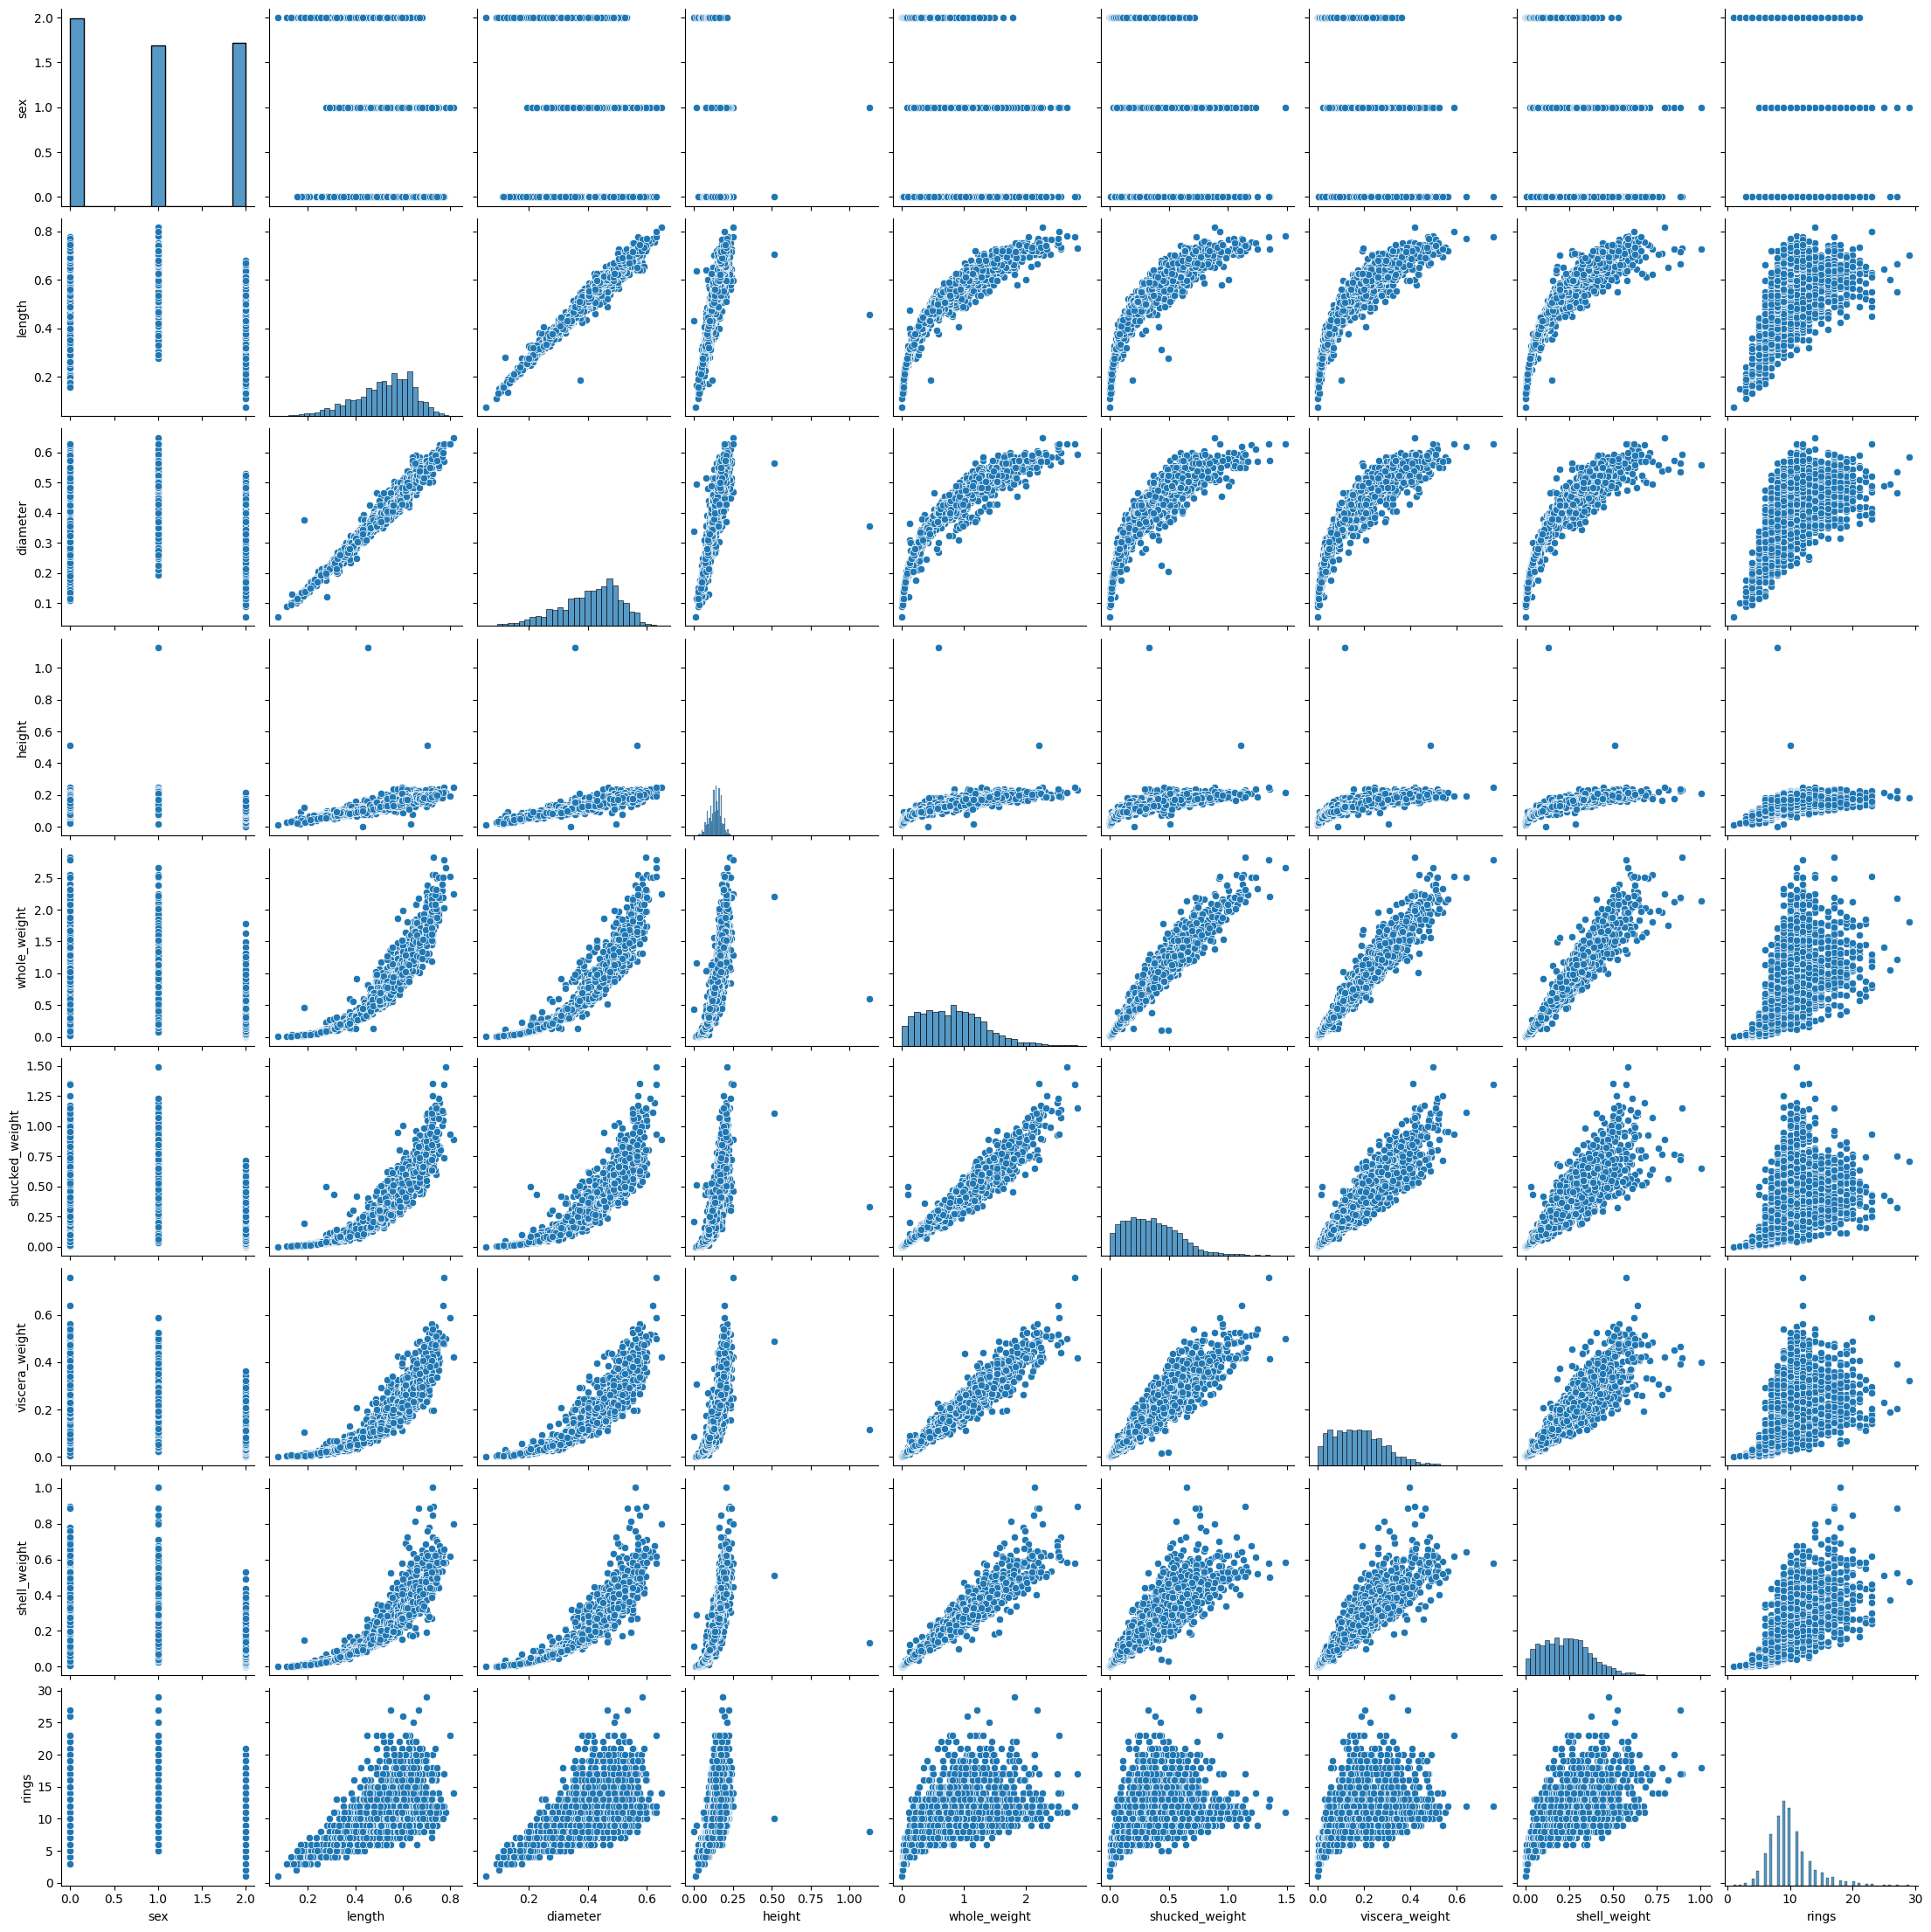

In [ ]:
sns.pairplot(data)

The first thing I see in this pairplot is the irrelvance of sex as a variable. All the lines are super similar. For this reason, I am not going to use it in my 'ideal' model to prevent overfitting. I am interested in all the different weight vaiables beause they are making similar graphs, I guess this kind of makes sense because they are all kind of proportional to eachother. However, I still think that there are differences, and they are relavent variables, so I will include them. I think shell length and width are also interesting, especially in te context of shell weight, so I will include those in a heirarchy to shell_weight. There is also a variable called height. Initially, I thought that I would defenitley be using it, but upon looking at the plots, it looks very 'static'. Finally, we have rings. Similar to trees, abalones develope rings with age, and age usualy has a close correlation with weight, and indirectly, value. For this reason, I will be including it as a predictor.

# **Causal Diagram**

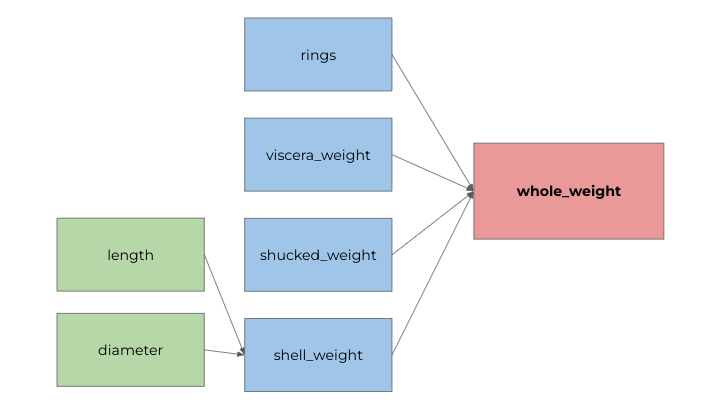

# **BART Model**

In [ ]:
# defining predictors and predicted
features = ["sex", "length", "diameter", "height", "shucked_weight", "viscera_weight", "shell_weight", "rings"]
X = data[features]
Y = data['whole_weight']

In [ ]:
with pm.Model() as model_BART:
    s = pm.Normal('s',20) # using a normal likelihood
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_BART = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

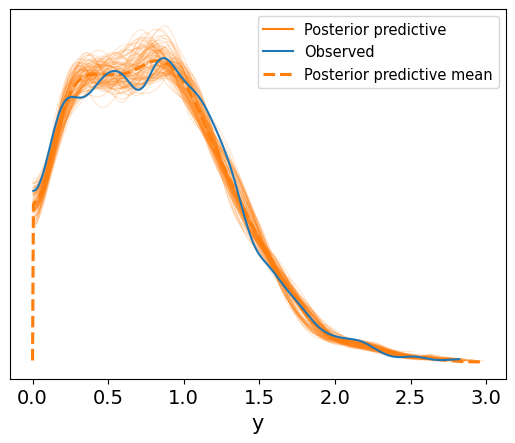

In [ ]:
pm.sample_posterior_predictive(idata_BART,model_BART, extend_inferencedata=True)
az.plot_ppc(idata_BART, num_pp_samples=100, colors=["C1", "C0", "C1"])

# **BART Model Analysis**

I am pretty happy with this, and also the convienience of BART. Obviously, It's not perfect, but it does a really good job on the downward slope. Specifically, the crux of the curve looks a little wonky. Instead of capturing the 2 peaks, it settled on one light dimple at the average height of the peaks. I can't say that I think that this model is better than my "ideal" model though, so I am going to plot the ICE to try to figure out how BART connected the predictors and if it used an interactions.

# **ICE Analysis**

/usr/local/lib/python3.11/dist-packages/pymc_bart/utils.py:516: UserWarning: The grid is smaller than the number of available variables to plot.
                Automatically adjusting the grid size.
  warnings.warn(


array([<Axes: xlabel='sex'>, <Axes: xlabel='length'>,
       <Axes: xlabel='diameter'>, <Axes: xlabel='height'>,
       <Axes: xlabel='shucked_weight'>, <Axes: xlabel='viscera_weight'>,
       <Axes: xlabel='shell_weight'>, <Axes: xlabel='rings'>],
      dtype=object)

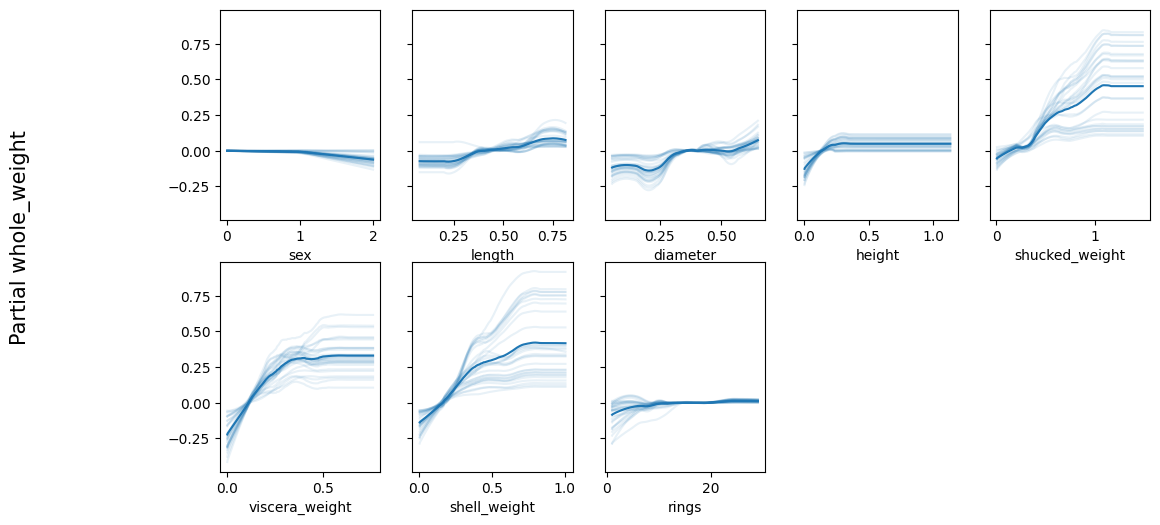

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Just as I suspected, the lines on the sex graph are all basically paralell. This shows that the data was just what was graphed, and that there were no secret interactions going on. Also, the horizontalness of the line shows its lack of interactions with anything. Another intersting thing is the similarity between the shell_weight and shucked_weight graphs. Its less that those graph looks similar, but the fact that viscera_weight looks so different from both. I thought that the various weight graphs would all just be proportional since all abalone are more or less coposed the same way, so its suprising to see this difference. It is also intersting to see how the viscera_weight ICE plot looks so different from the pairplot representation. The biggest thing that stood out to me interaction-wise was the plots for the weights. I'm curious to see what those actually are. Final note, looks like I am on the right track about the shell length and diameter interactions, so thats cool :)

# **Variable Importance Analysis**

<Axes: ylabel='R²'>

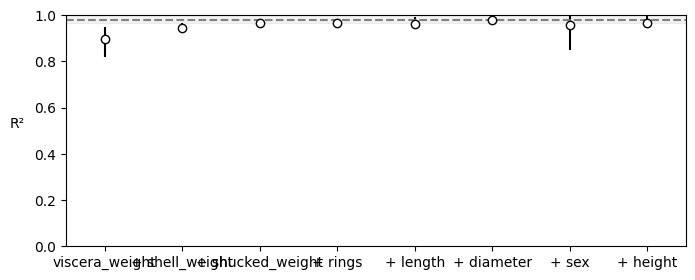

In [ ]:
vi_graph = pmb.compute_variable_importance(idata_BART, μ_, X)
pmb.plot_variable_importance(vi_graph)

Hmmm. There's a lot to unpack here I think. First of all, I than I came to some hasty conclusions initially. Sex isn't as insignificant as I thought it was. I thougt adding it would actually lower the overall efficiency of my model, bu it din't. I was also confident that rings was also an important addition, but I guess not. Anyways, onto my victories. Looks likeall three weights was pretty essential, as I suspected. The only other thing that stands out to me it the height and length variables. I didn't necessarily think that they would make or break my model, but I was pretty confident that they would have some influence at least... The main reason I made this was just to check my initial eveluation of the predictors against BART's, so not much to say here.

# **Comparing BART and Predicted Model**

(spoiler alert: didn't work)

In [ ]:
model_predicted = bmb.Model("whole_weight ~ viscera_weight + shucked_weight + shell_weight:height + shell_weight:length", data=data)
#fit the model
idata_predicted = model_predicted.fit(idata_kwargs={'log_likelihood': True})

Output()

Choosing shucked_weight and viscera_weight to interprest because I can only choose 2/3 and thoe are the ones that arent in interactions.

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 640x480 with 52 Axes>,
 array([[<Axes: title={'center': 'shucked_weight = 0.001'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.0313469387755102'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.06169387755102041'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.09204081632653062'}, xlabel='shucked_weight', ylabel='whole_weight'>],
        [<Axes: title={'center': 'shucked_weight = 0.12238775510204082'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.15273469387755104'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.18308163265306124'}, xlabel='shucked_weight', ylabel='whole_weight'>,
         <Axes: title={'center': 'shucked_weight = 0.21342857142857144'}, xlabel='shucked_weight', ylabel='whole_wei

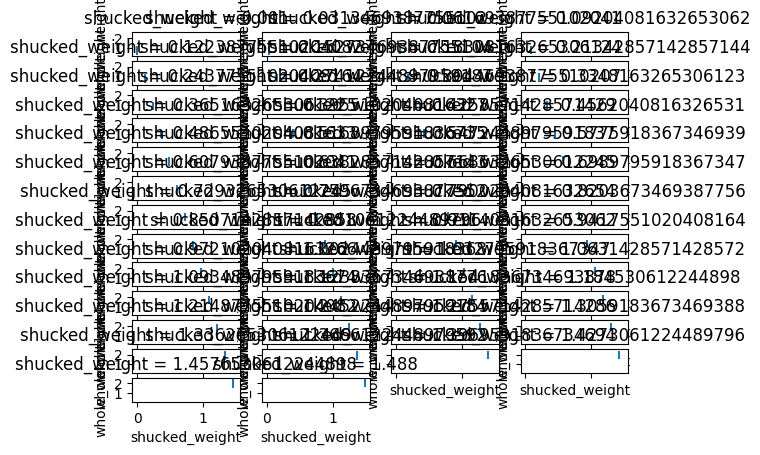

In [ ]:
bmb.interpret.plot_predictions(model_predicted, idata_predicted, ["shucked_weight", "viscera_weight"],
                               subplot_kwargs={"group":None, "panel":"shucked_weight"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

Ok, so thats completley unreadable do im going to seperate it into two different interpretations. One for viscera_weight, and one for shucked_weight

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


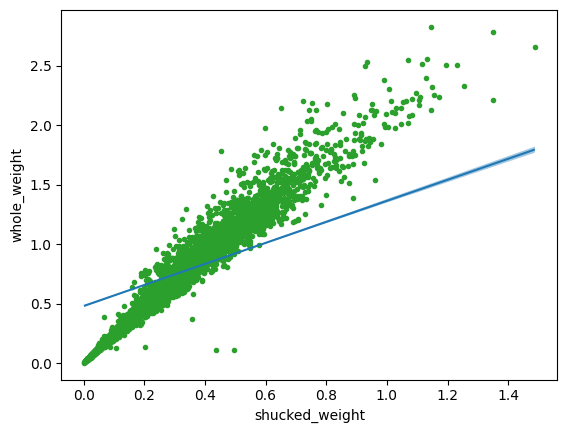

In [ ]:
bmb.interpret.plot_predictions(model_predicted, idata_predicted, ["shucked_weight"],
                              # subplot_kwargs={"group":None, "panel":"shucked_weight"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})
plt.plot(data.shucked_weight, data.whole_weight, "C2.", zorder=-3)

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


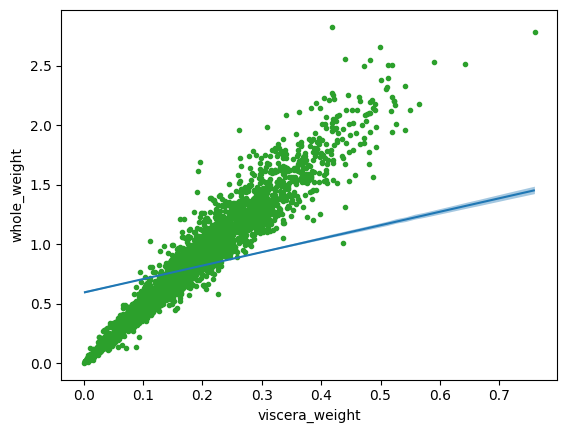

In [ ]:
bmb.interpret.plot_predictions(model_predicted, idata_predicted, ["viscera_weight"],
                               #subplot_kwargs={"group":None, "panel":"viscera_weight"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})
plt.plot(data.viscera_weight, data.whole_weight, "C2.", zorder=-3)

Oof, this lowkey sucks. I was so sonfident in my Abalone prediction skills :(. Oh well, its good to know i guess. It's kind of suprising how little variation bambi gave my variables, theres no allowance at all on those lines..

In [ ]:
# This disn't work, bc to make it work I would have to make it pymc based which is a lot of work, especially since I don't know a lot about abalones so priors will be too complicated
r2_predicted = az.r2_score(idata_predicted)
r2_predicted

TypeError: r2_score() missing 1 required positional argument: 'y_pred'

# **Conclusion + References**

In conclusion, I 🫶 BART! It was cool since it was so easy and I am very happy with my final posterior prediction. Though I am suprised at how of my orignal predction was, I do wish I had found a way to get the r^2 value and find exactly HOW off I was. Anyway, at least I have solved the mystery of how much that abalone weighs.

Final side note: I still dont know what was up with the crazy top of my ppc, but that was the best it got, so I'm just going to leave it as is

https://www.re3data.org/repository/r3d100010960
https://bambinos.github.io/bambi/
https://emojipedia.org/heart-hands